In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [6]:
%load_ext autoreload
%autoreload 2
import cProfile
from datetime import datetime
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

config_path = "config/mcts_helm.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)

output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
logger = make_logger(output_dir)

transition_conf = conf.get("transition_conf", {})
if "model_dir" in transition_conf:
    transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
lang_path = conf.get("lang_path")
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
    lang_path = add_sep(transition_conf["model_dir"]) + lang_name
lang = Language.load(lang_path, device=conf.get("device"))
transition_class = class_from_package("transition", conf["transition_class"])
transition = transition_class(lang=lang, logger=logger, **transition_conf)

reward_class = class_from_package("reward", conf.get("reward_class"))
reward = reward_class(**conf.get("reward_conf", {}))
policy_class = class_from_package("policy", conf.get("policy_class"))
policy = policy_class(**conf.get("policy_conf", {}))

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

Is CUDA available: False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Starting generation...
1- time: 0.00, reward: -0.7405554689261359, node: PEPTIDE1{Y.N.F.L.M.[am]}$$$$
2- time: 0.00, reward: 0.9364834176311172, node: PEPTIDE1{V.L.Q.L.L.L.V.[Nle].A.R.V.S}$$$$
3- time: 0.08, reward: -0.9086126776884885, node: PEPTIDE1{T.P.Q.R.A.R.R.R.K.K.R.G}$$$$
4- time: 0.08, reward: -0.9419827505378605, node: PEPTIDE1{[ac].Y.D.A.I.F.T.N.S.Y.R.K.V.L.G.Q.L.S.A.R.K.L.L.Q.D.I.L.[am]}$$$$
5- time: 0.08, reward: -0.9178556354175516, node: PEPTIDE1{Y.E.L.L.H.G.A.G.N.H.A.A.G.I.L.T.L.[am]}$$$$
6- time: 0.18, reward: -0.8840130335515616, node: PEPTIDE1{R.[dP].[dK].P.Q.[dQ].F.F.G.[dL].M.[am]}$$$$
7- time: 0.33, reward: -0.8927884954267828, node: PEPTIDE1{G.L.F.G.Y.S.S.K.G.R.F.[am]}$$$$
8- time: 0.33, reward: -0.9092108315558964, node: PEPTIDE1{G.V.W.M.A.E.L.G.A.G.S.L.N.S.V}$$$$
9- time: 0.44, reward: -0.7473287665357273, node: PEPTIDE1{F.K.H.V.F.A}$$$$
10- time: 0.44, reward: -0.5865475860699849, node: PEPTIDE1{F.F.R.W}$$$$
11- time: 0.49, reward: 0.9367881247242006, node: PEP

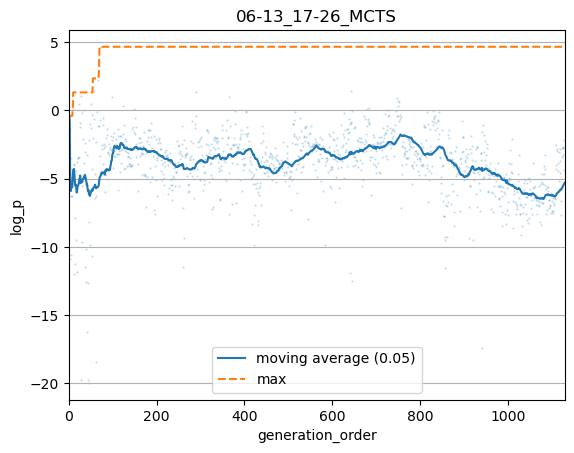

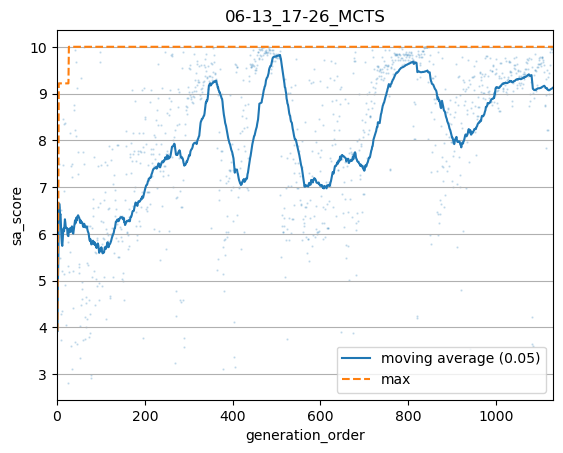

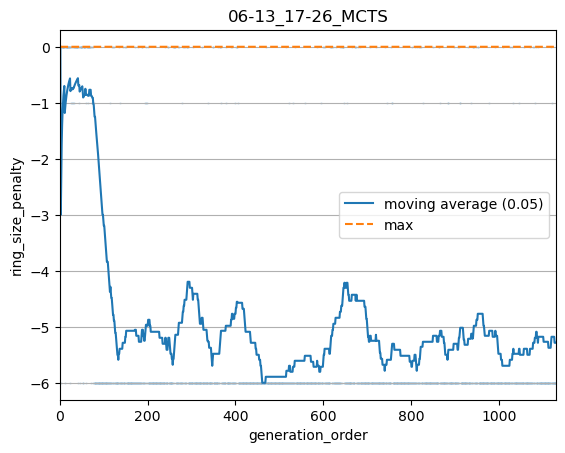

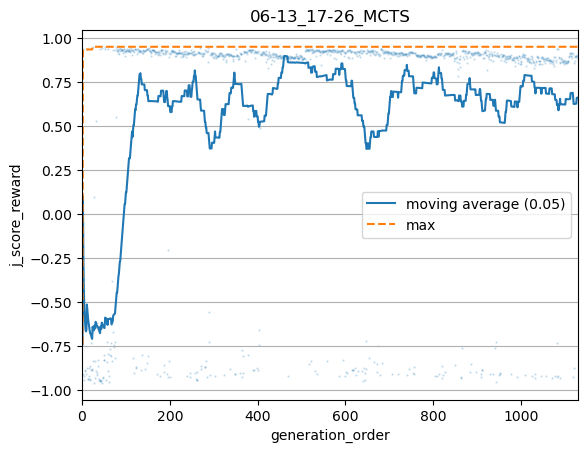

number of generated nodes: 1130
valid rate: 0.712322695035461
unique rate: 0.788563829787234
node_per_sec: 18.80038760131947


In [7]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **conf.get("generator_conf", {}))
src = os.path.join(repo_root, config_path)
dst = os.path.join(output_dir, "setting.yaml")
shutil.copy(src, dst)

generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
# cProfile.run("generator.generate(root=root, **generation_conf)"")
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts
load_path = os.path.join(output_dir, "06-09_22-15_MCTS_PUCT/test.mcts")
generator = MCTS.load(load_path, transition)